In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel('Encoded_movie_data_with_budget_new 1.xlsx')
data = data[data['domestic_opening'] >= 10000]
data = data[data['Documentary'] == 0]
data = data.drop(columns=['Budget_new', 'movie_searched'])
data['big_production'] = (data['big_production'] == 'Yes').astype(int)

def log_transform(x):
    return np.log(x + 1)  # log(0) is undefined so we use log(x+1)

def sqrt_transform(x):
    return np.sqrt(x)

# Split data into features and target
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('domestic_opening')
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline for features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Pipeline configurations for each transformation and expansion
transformations = {'original': lambda x: x, 'log': log_transform, 'sqrt': sqrt_transform}
expansions = [1, 2]

# Evaluate each model configuration
models = {}
for key, func in transformations.items():
    y_transformed = func(data['domestic_opening'])
    X = data.drop('domestic_opening', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

    for degree in expansions:
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        models[f'{key}_degree_{degree}'] = (r2, rmse)
        print(f"Model: {key}, Polynomial Degree: {degree}, R^2: {r2:.4f}, RMSE: {rmse:.4f}")

Model: original, Polynomial Degree: 1, R^2: 0.5622, RMSE: 13979520.3230
Model: original, Polynomial Degree: 2, R^2: 0.6345, RMSE: 12772610.3199
Model: log, Polynomial Degree: 1, R^2: 0.3401, RMSE: 2.1922
Model: log, Polynomial Degree: 2, R^2: 0.4036, RMSE: 2.0842
Model: sqrt, Polynomial Degree: 1, R^2: 0.5851, RMSE: 1659.8198
Model: sqrt, Polynomial Degree: 2, R^2: 0.6136, RMSE: 1601.7713
Models have been evaluated and exported.


C:\Users\olive\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


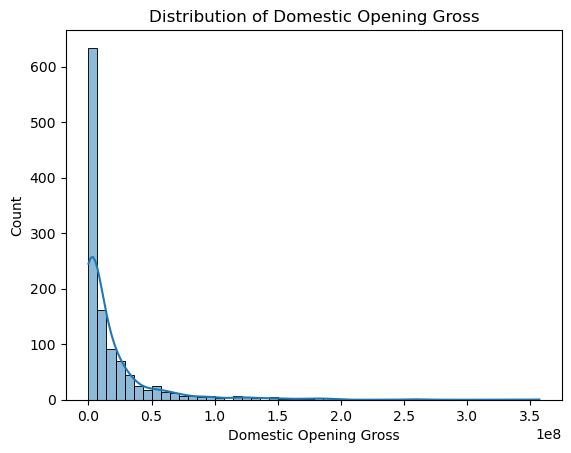

In [17]:
import seaborn as sns

sns.histplot(data['domestic_opening'], kde=True, bins=50)
plt.xlabel('Domestic Opening Gross')
plt.title('Distribution of Domestic Opening Gross')
plt.show()

C:\Users\olive\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


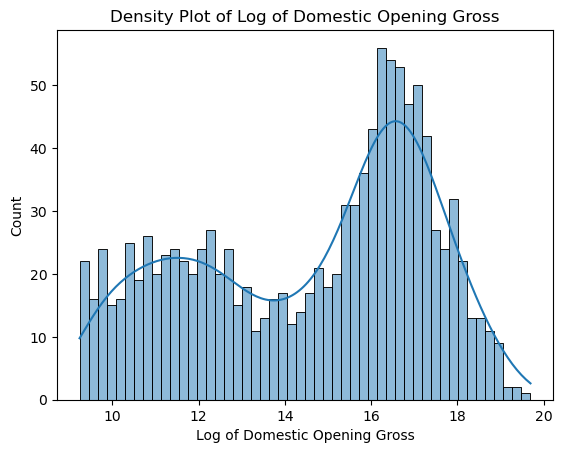

In [20]:
import numpy as np

data['log_domestic_opening'] = np.log(data['domestic_opening'] + 1)
import seaborn as sns

sns.histplot(data['log_domestic_opening'], kde=True, bins=50)
plt.xlabel('Log of Domestic Opening Gross')
plt.title('Density Plot of Log of Domestic Opening Gross')
plt.show()

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Load and preprocess data
data = pd.read_excel('Encoded_movie_data_with_budget_new 1.xlsx')
data = data[data['domestic_opening'] >= 10000]
data = data[data['Documentary'] == 0]
data = data.drop(columns=['Budget_new', 'movie_searched', 'Documentary'])
data['big_production'] = (data['big_production'] == 'Yes').astype(int)

def log_transform(x):
    return np.log(x + 1)  # +1 to avoid log(0)

def reverse_log_transform(y):
    return np.exp(y) - 1

# Split data into features and target
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('domestic_opening')
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline for features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Evaluate models for each transformation and polynomial degree
transformations = {'original': lambda x: x, 'log': log_transform}
expansions = [1, 2]
models = {}

for key, func in transformations.items():
    y_transformed = func(data['domestic_opening'])
    X = data.drop('domestic_opening', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

    for degree in expansions:
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))
        ])
        pipe.fit(X_train, y_train)
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)

        # Reverse transformation if necessary
        if key == 'log':
            y_train_orig = reverse_log_transform(y_train)
            y_train_pred_orig = reverse_log_transform(y_train_pred)
            y_test_orig = reverse_log_transform(y_test)
            y_test_pred_orig = reverse_log_transform(y_test_pred)
        else:
            y_train_orig = y_train
            y_train_pred_orig = y_train_pred
            y_test_orig = y_test
            y_test_pred_orig = y_test_pred

        train_rmse = mean_squared_error(y_train_orig, y_train_pred_orig, squared=False)
        train_r2 = r2_score(y_train_orig, y_train_pred_orig)
        test_rmse = mean_squared_error(y_test_orig, y_test_pred_orig, squared=False)
        test_r2 = r2_score(y_test_orig, y_test_pred_orig)
        models[f'{key}_degree_{degree}'] = (train_r2, train_rmse, test_r2, test_rmse)

        print(f"Model: {key}, Polynomial Degree: {degree}, Train R^2: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}, Test R^2: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}")


Model: original, Polynomial Degree: 1, Train R^2: 0.6276, Train RMSE: 18792101.0708, Test R^2: 0.5250, Test RMSE: 27141985.6957
Model: original, Polynomial Degree: 2, Train R^2: 0.7600, Train RMSE: 15085103.4650, Test R^2: 0.5644, Test RMSE: 25992206.1521
Model: log, Polynomial Degree: 1, Train R^2: 0.1025, Train RMSE: 29174314.1112, Test R^2: 0.1680, Test RMSE: 35921981.0291
Model: log, Polynomial Degree: 2, Train R^2: 0.0282, Train RMSE: 30357385.0820, Test R^2: -10.1033, Test RMSE: 131224012.1693
Models have been evaluated and exported.


In [41]:
# Load and preprocess data
data = pd.read_excel('Encoded_movie_data_with_budget_new 1.xlsx')
data = data[data['domestic_opening'] >= 10000]
data = data[data['Documentary'] == 0]
data = data.drop(columns=['Budget_new', 'movie_searched', 'Documentary'])
data['big_production'] = (data['big_production'] == 'Yes').astype(int)

y = data['domestic_opening']
X = data.drop('domestic_opening', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base model

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)) 
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ElasticNet Model Pipeline with polynomial features
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Calculate residuals
#residuals = y_train - y_pred

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred_filtered, squared=False)
r2 = r2_score(y_test, y_pred_filtered)

print("RMSE:", rmse)
print("R^2:", r2)

RMSE: 25056635.464753512
R^2: 0.5951709394906093


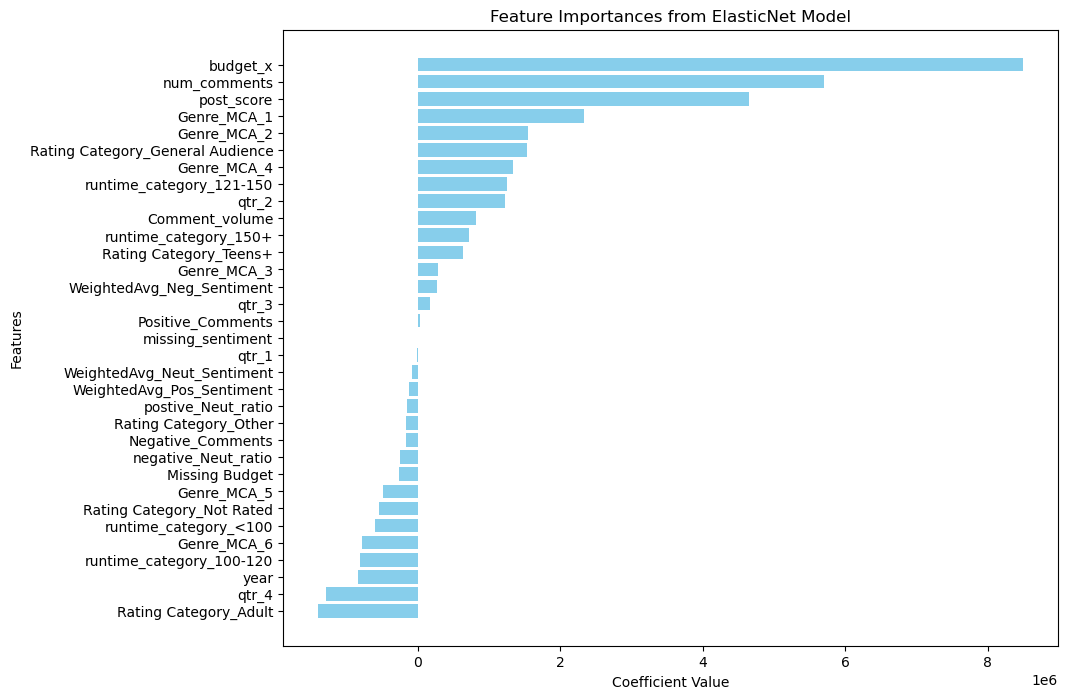

In [34]:
coef = model.named_steps['regressor'].coef_

feature_names = []
# Numeric features (including polynomial features)
feature_names.extend(preprocessor.named_transformers_['num'].named_steps['poly'].get_feature_names_out(input_features=numeric_features))
# Categorical features
categories = [preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_[i].tolist() for i in range(len(categorical_features))]
for cat, names in zip(categorical_features, categories):
    feature_names.extend([f"{cat}_{name}" for name in names])

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coef})
feature_importance = feature_importance[feature_importance['Importance'] != 0]  # Filter out zero coefficients
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances from ElasticNet Model')
plt.show()

In [43]:
from sklearn.inspection import permutation_importance

model.fit(X_train, y_train)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
feature_importances = pd.DataFrame(result.importances_mean, index=X.columns, columns=["Importance"])
important_features = feature_importances[feature_importances["Importance"] > 0.005].index

# Filter the original dataset
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

numeric_features_filtered = [feat for feat in numeric_features if feat in important_features]
categorical_features_filtered = [feat for feat in categorical_features if feat in important_features]

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features_filtered),
    ('cat', categorical_transformer, categorical_features_filtered)
])

# Update the model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))
])

model.fit(X_train_filtered, y_train)

y_pred_filtered = model.predict(X_test_filtered)

from sklearn.metrics import mean_squared_error, r2_score

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred_filtered, squared=False)
r2 = r2_score(y_test, y_pred_filtered)

print("RMSE:", rmse)
print("R^2:", r2)


RMSE: 25056635.464753512
R^2: 0.5951709394906093


In [45]:
y_train_pred = model.predict(X_train_filtered)

# Calculate RMSE for the training data
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate R^2 for the training data
r2_train = r2_score(y_train, y_train_pred)

print(f"Training RMSE: {rmse_train}")
print(f"Training R²: {r2_train}")

Training RMSE: 17124420.992807258
Training R²: 0.6907725691735591
